# Kaggle 2017 March Madness Tourny

In [88]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

#Required for other guy's logistic regression 
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

#Additional to Implement my Logistic Regression
from patsy import dmatrices 
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
print(plt.style.available)

['seaborn-dark', 'seaborn-deep', 'seaborn-talk', 'grayscale', 'seaborn-notebook', 'seaborn-muted', 'seaborn-white', 'ggplot', 'dark_background', 'seaborn-darkgrid', 'seaborn-colorblind', 'seaborn-pastel', 'fivethirtyeight', 'seaborn-whitegrid', 'seaborn-bright', 'seaborn-dark-palette', 'classic', 'seaborn', 'seaborn-paper', 'bmh', 'seaborn-poster', 'seaborn-ticks']


In [3]:
file_path = 'D:\_data_science_data\\2017_march_madness\\'

# Other Guy's Logistic Regression Example

In [4]:
df_seeds = pd.read_csv(file_path+"TourneySeeds.csv")
df_seeds[:6]

,Season,Seed,Team
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
5,1985,W06,1208


In [5]:
df_tour = pd.read_csv(file_path+"TourneyCompactResults.csv")
df_tour[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
5,1985,136,1246,66,1449,58,N,0


In [6]:
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)

In [7]:
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [8]:
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

In [9]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

In [10]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_concat['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_concat['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))

In [11]:
X_train = df_for_predictions.seed_diff.values.reshape(-1,1)
y_train = df_for_predictions.result.values
X_train, y_train = shuffle(X_train, y_train)

In [12]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5536, with best C: 0.01


In [13]:
X = np.arange(-16, 16).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

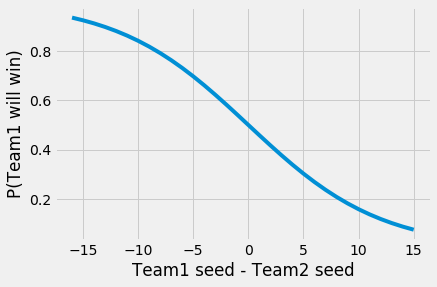

In [14]:
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [15]:
df_sample_sub = pd.read_csv(file_path + 'sample_submission.csv')
n_test_games = len(df_sample_sub)
#df_sample_sub[:6]

In [16]:
def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))
#We loop over each row in the sample_submission.csv file. For each row, we extract the year and the teams playing. 
#We then look up the seeds for each of those teams in that season. Finally we add the seed difference to an array.

In [17]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.id)
    # There absolutely must be a better way of doing this!
    t1_seed = df_seeds[(df_seeds.Team == t1) & (df_seeds.Season == year)].n_seed.values[0]
    t2_seed = df_seeds[(df_seeds.Team == t2) & (df_seeds.Season == year)].n_seed.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [18]:
preds = clf.predict_proba(X_test)[:,1]

In [19]:
clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.pred = clipped_preds
df_sample_sub.head()

,id,pred
0,2013_1103_1107,0.622432
1,2013_1103_1112,0.268988
2,2013_1103_1125,0.458439
3,2013_1103_1129,0.541561
4,2013_1103_1137,0.458439


In [20]:
df_sample_sub.to_csv('other_guys_logreg_on_seed.csv', index=False)

# AJ's Work and Predictions!

## What is in the data:

### Teams

In [21]:
df_teams = pd.read_csv(file_path+"Teams.csv")
df_teams[:6]

,Team_Id,Team_Name
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M
5,1106,Alabama St


### Regular Season Compact Results
* "season" - this is the year of the associated entry in seasons.csv (the year in which the final tournament occurs)
* "daynum" - this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "dayzero" date in the "seasons.csv" file. For example, the first game in the file was daynum=20. Combined with the fact from the "season.csv" file that day zero was 10/29/1984, that means the first game was played 20 days later, or 11/18/1984. There are no teams that ever played more than one game on a given date, so you can use this fact if you need a unique key. In order to accomplish this uniqueness, we had to adjust one game's date. In March 2008, the SEC postseason tournament had to reschedule one game (Georgia-Kentucky) to a subsequent day, so Georgia had to actually play two games on the same day. In order to enforce this uniqueness, we moved the game date for the Georgia-Kentucky game back to its original date.
* "wteam" - this identifies the id number of the team that won the game, as listed in the "teams.csv" file. No matter whether the game was won by the home team or visiting team, "wteam" always identifies the winning team.
* "wscore" - this identifies the number of points scored by the winning team.
* "lteam" - this identifies the id number of the team that lost the game.
* "lscore" - this identifies the number of points scored by the losing team.
* "numot" - this indicates the number of overtime periods in the game, an integer 0 or higher.
* "wloc" - this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting team, this value will be "A". If it was played on a neutral court, then this value will be "N". Sometimes it is unclear whether the site should be considered neutral, since it is near one team's home court, or even on their court during a tournament, but for this determination we have simply used the Kenneth Massey data in its current state, where the "@" sign is either listed with the winning team, the losing team, or neither team.

In [22]:
df_rscr = pd.read_csv(file_path+"RegularSeasonCompactResults.csv")
df_rscr[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
5,1985,25,1218,79,1337,78,H,0


### Regular Season Detailed Results
This file is a more detailed set of game results, covering seasons 2003-2016. This includes team-level total statistics for each game (total field goals attempted, offensive rebounds, etc.) The column names should be self-explanatory to basketball fans (as above, "w" or "l" refers to the winning or losing team):

* wfgm - field goals made
* wfga - field goals attempted
* wfgm3 - three pointers made
* wfga3 - three pointers attempted
* wftm - free throws made
* wfta - free throws attempted
* wor - offensive rebounds
* wdr - defensive rebounds
* wast - assists
* wto - turnovers
* wstl - steals
* wblk - blocks
* wpf - personal fouls

In [23]:
df_rsdr = pd.read_csv(file_path+"RegularSeasonDetailedResults.csv")
df_rsdr[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
5,2003,11,1458,81,1186,55,H,0,26,57,...,11,12,17,6,22,8,19,4,3,25


### TourneyCompactResults

This file identifies the game-by-game NCAA tournament results for all seasons of historical data. The data is formatted exactly like the regular_season_compact_results.csv data. Note that these games also include the play-in games (which always occurred on day 134/135) for those years that had play-in games.

In [24]:
df_tcr = pd.read_csv(file_path+"TourneyCompactResults.csv")
df_tcr[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
5,1985,136,1246,66,1449,58,N,0


### TourneyDetailedResults

This file contains the more detailed results for tournament games from 2003 onward.

In [25]:
df_tdr = pd.read_csv(file_path+"TourneyDetailedResults.csv")
df_tdr[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
5,2003,136,1163,58,1140,53,N,0,17,52,...,17,11,13,15,26,11,11,8,4,22


### TourneySeeds

This file identifies the seeds for all teams in each NCAA tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on the bracket structure.

* "season" - the year
* "seed" - this is a 3/4-character identifier of the seed, where the first character is either W, X, Y, or Z (identifying the region the team was in) and the next two digits (either 01, 02, ..., 15, or 16) tells you the seed within the region. For play-in teams, there is a fourth character (a or b) to further distinguish the seeds, since teams that face each other in the play-in games will have the same first three characters. For example, the first record in the file is seed W01, which means we are looking at the #1 seed in the W region (which we can see from the "seasons.csv" file was the East region). This seed is also referenced in the "tourney_slots.csv" file that tells us which bracket slots face which other bracket slots in which rounds.
* "team" - this identifies the id number of the team, as specified in the teams.csv file

In [26]:
df_seeds = pd.read_csv(file_path+"TourneySeeds.csv")
df_seeds[:6]

,Season,Seed,Team
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
5,1985,W06,1208


### TourneySlots

This file identifies the mechanism by which teams are paired against each other, depending upon their seeds. Because of the existence of play-in games for particular seed numbers, the pairings have small differences from year to year. If there were N teams in the tournament during a particular year, there were N-1 teams eliminated (leaving one champion) and therefore N-1 games played, as well as N-1 slots in the tournament bracket, and thus there will be N-1 records in this file for that season.

* "season" - the year
* "slot" - this uniquely identifies one of the tournament games. For play-in games, it is a three-character string identifying the seed fulfilled by the winning team, such as W16 or Z13. For regular tournament games, it is a four-character string, where the first two characters tell you which round the game is (R1, R2, R3, R4, R5, or R6) and the second two characters tell you the expected seed of the favored team. Thus the first row is R1W1, identifying the Round 1 game played in the W bracket, where the favored team is the 1 seed. As a further example, the R2W1 slot indicates the Round 2 game that would have the 1 seed from the W bracket, assuming that all favored teams have won up to that point. The slot names are different for the final two rounds, where R5WX identifies the national semifinal game between the winners of regions W and X, and R5YZ identifies the national semifinal game between the winners of regions Y and Z, and R6CH identifies the championship game. The "slot" value is used in other columns in order to represent the advancement and pairings of winners of previous games.
* "strongseed" - this indicates the expected stronger-seeded team that plays in this game. For Round 1 games, a team seed is identified in this column (as listed in the "seed" column in the tourney_seeds.csv file), whereas for subsequent games, a slot is identified in this column. In the first record of this file (slot R1W1), we see that seed W01 is the "strongseed", which during the 1985 tournament would have been Georgetown. Whereas for games from Round 2 or later, rather than a team seed, we will see a "slot" referenced in this column. So in the 33rd record of this file (slot R2W1), it tells us that the winners of slots R1W1 and R1W8 will face each other in Round 2. Of course, in the last few games of the tournament - the national semifinals and finals - it's not really meaningful to talk about a "strong seed" or "weak seed", but those games are represented in the same format for the sake of uniformity.
* "weakseed" - this indicates the expected weaker-seeded team that plays in this game, assuming all favored teams have won so far. For Round 1 games, a team seed is identified in this column (as listed in the "seed" column in the tourney_seeds.csv file), whereas for subsequent games, a slot is identified in this column.

In [27]:
df_slots = pd.read_csv(file_path+"TourneySlots.csv")
df_slots[:6]

,Season,Slot,Strongseed,Weakseed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14
3,1985,R1W4,W04,W13
4,1985,R1W5,W05,W12
5,1985,R1W6,W06,W11


## Sample Submission
What to predict

Stage 1 - You should submit predicted probabilities for every possible matchup in the past 4 NCAA tournaments (2013-2016).

Stage 2 - You should submit predicted probabilities for every possible matchup before the 2017 tournament begins.

Refer to the Timeline page for specific dates. In both stages, the sample submission will tell you which games to predict.

The file you submit will depend on whether the competition is in stage 1 (historical model building) or stage 2 (the 2017 tournament). Sample submission files will be provided for both stages. The format is a list of every possible matchup between the tournament teams. Since team1 vs. team2 is the same as team2 vs. team1, we only include the game pairs where team1 has the lower team id. For example, in a tournament of 68 teams (64 + 4 play-in teams), you will predict (68*67)/2  = 2278 matchups. 

Each game has a unique id created by concatenating the season in which the game was played, the team1 id, and the team2 id. For example, "2013_1104_1129" indicates team 1104 played team 1129 in the year 2013. You must predict the probability that the team with the lower id beats the team with the higher id.

The resulting submission format looks like the following, where "pred" represents the predicted probability that the first team will win:

    id, pred
    2013_1103_1107, 0.5

that is that there is a 50% probability of team 1103 beating team 1107

In [147]:
df_sample_sub = pd.read_csv(file_path + 'sample_submission.csv')
df_sample_sub

,id,pred
0,2013_1103_1107,0.5
1,2013_1103_1112,0.5
2,2013_1103_1125,0.5
3,2013_1103_1129,0.5
4,2013_1103_1137,0.5
5,2013_1103_1139,0.5
6,2013_1103_1143,0.5
7,2013_1103_1153,0.5
8,2013_1103_1160,0.5
9,2013_1103_1161,0.5


In [29]:
len(df_sample_sub)

9112

### Some Basketball Metrics to Consider (calculate)

* AST: Assist Ratio - the percentage of a team's possessions that ends in an assist. Assist Ratio = (Assists x 100) divided by [(FGA + (FTA x 0.44) + Assists + Turnovers]
     
* TO: Turnover Ratio - the percentage of a team's possessions that end in a turnover. Turnover Ratio = (Turnover x 100) divided by [(FGA + (FTA x 0.44) + Assists + Turnovers]
     
* ORR: Offensive rebound rate = (100 x Offensive Rebounds x Team Minutes Played / 5) / [Minutes Played x (Team Offensive Rebounds + Opposing Team Defensive Rebounds)]
     
* DRR: Defensive rebound rate = (100 x Defensive Rebounds x Team Minutes Played / 5) / [Minutes Played x (Team Defensive Rebounds + Opposing Team Offensive Rebounds)]
     
* REBR: Rebound Rate - the percentage of missed shots that a team rebounds. Rebound Rate = (Rebounds x Team Minutes) divided by [Player Minutes x (Team Rebounds + Opponent Rebounds)]
     
* EFF FG%: Effective Field Goal Percentage
     
* TS%: True Shooting Percentage - what a team's shooting percentage would be if we accounted for free throws and 3-pointers. True Shooting Percentage = (Total points x 50) divided by [(FGA + (FTA x 0.44)]
     
* OFF EFF: Offensive Efficiency - the number of points a team scores per 100 possessions.
     
* DEF EFF: Defensive Efficiency - the number of points a team allows per 100 possessions.
     
* Eff = (PTS + REB + AST + STL + BLK - ((FGA-FAM) + (FTA-FTM) + TO))
     
* Performance Index Rating = (PTS + REB + AST + STL + BLK + Fouls Draw) - (MFG + MFT + TO + Shots Blocked + Fouls Comitted)

### Also of Note:
* Games = 2x 20 minute halfs
* OT = 5 minutes each
* Game Length = 40 + 5x OTs

# Hypothesis #1
### I can accuratly predict game outcomes based on logistic regression with the following coeficients:
    - Difference in Seed
    - Difference in Season Avg Assist Ratio
    - Difference in Season Avg Turnover Ratio
    - Difference in Season Avg Rebound Rate
    - Difference in Season Avg EFF FG%
    - Difference in Season Avg TS%
    - Difference in Season Avg Performance Index Rating
    - Difference in Season Avg Winning Point Spread
    - Difference in Season Avg Losing Point Spread
    

In [30]:
# Step 1: Using RSDR: Calculate By Team, By Year Statistics to include in regression analysis

In [31]:
teams = list(set(df_teams['Team_Id']))
seasons = [2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
print(seasons)
print('Numer of Teams: {}'.format(len(teams)))

[2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Numer of Teams: 364


In [85]:
teams[0]

1101

In [83]:
#ACU doesnt have data prior to 2013... some teams dont have data for every season!
#acu_2016 = df_rsdr[np.logical_and(df_rsdr['Season']==seasons[-1],np.logical_or(df_rsdr['Wteam']==teams[0],df_rsdr['Lteam']==teams[0]))]

#acu_2016

In [84]:
#Average Winning and Losing Point Spread
#avg_winning_point_spread = acu_2016.groupby('Wteam').mean().loc[1101]['Wscore']-acu_2016.groupby('Wteam').mean().loc[1101]['Lscore']
#avg_losing_point_spread = acu_2016.groupby('Lteam').mean().loc[1101]['Wscore']-acu_2016.groupby('Wteam').mean().loc[1101]['Lscore']

#avg_winning_point_spread, avg_losing_point_spread

In [35]:
#2016 Teams
temp = list(set(df_rsdr[df_rsdr['Season']==2016]["Wteam"]))
temp += list(set(df_rsdr[df_rsdr['Season']==2016]["Lteam"]))
teams2016 = list(set(temp))
len(teams2016)

351

In [36]:
#for team in teams2016:
#team = teams2016[0]

def team_ratings(team, season=2016):

    temp_df = df_rsdr[np.logical_and(df_rsdr['Season']==season,np.logical_or(df_rsdr['Wteam']==team,df_rsdr['Lteam']==team))]

    num_games = len(temp_df)
    #print("Num Games: {}".format(num_games))

    wins = len(temp_df[temp_df['Wteam']==team])
    #print("Wins: {}".format(wins))

    losses = len(temp_df[temp_df['Lteam']==team])
    #print("Losses: {}".format(losses))

    winning_avg_min = ((wins * 40) + (temp_df.groupby('Wteam').mean().loc[team]['Numot']*5))/wins
    #print("Winning Min Played: {}".format(winning_avg_min))

    losing_avg_min = ((losses * 40) + (temp_df.groupby('Lteam').mean().loc[team]['Numot']*5))/losses
    #print("Losing Min Played: {}".format(losing_avg_min))

    avg_winning_point_spread = temp_df.groupby('Wteam').mean().loc[team]['Wscore']-temp_df.groupby('Wteam').mean().loc[team]['Lscore']
    #print("Avg Winning Point Spread: {}".format(avg_winning_point_spread))

    avg_losing_point_spread = temp_df.groupby('Lteam').mean().loc[team]['Wscore']-temp_df.groupby('Wteam').mean().loc[team]['Lscore']
    #print("Avg Losing Point Spread: {}".format(avg_losing_point_spread))

    #AST: Assist Ratio = (Assists x 100) divided by [(FGA + (FTA x 0.44) + Assists + Turnovers]
    AST = (temp_df.groupby('Wteam').mean().loc[team]['Wast']*100) / (temp_df.groupby('Wteam').mean().loc[team]['Wfga']+(temp_df.groupby('Wteam').mean().loc[team]['Wfta']*0.44)+temp_df.groupby('Wteam').mean().loc[team]['Wast']+temp_df.groupby('Wteam').mean().loc[team]['Wto'])*(wins/num_games)+(temp_df.groupby('Lteam').mean().loc[team]['Last']*100) / (temp_df.groupby('Lteam').mean().loc[team]['Lfga']+(temp_df.groupby('Lteam').mean().loc[team]['Lfta']*0.44)+temp_df.groupby('Lteam').mean().loc[team]['Last']+temp_df.groupby('Lteam').mean().loc[team]['Lto'])*(losses/num_games)
    #print("AST: {}".format(AST))

    #TO: Turnover Ratio = (Turnover x 100) divided by [(FGA + (FTA x 0.44) + Assists + Turnovers]     
    TO = (temp_df.groupby('Wteam').mean().loc[team]['Wto']*100) / (temp_df.groupby('Wteam').mean().loc[team]['Wfga']+(temp_df.groupby('Wteam').mean().loc[team]['Wfta']*0.44)+temp_df.groupby('Wteam').mean().loc[team]['Wast']+temp_df.groupby('Wteam').mean().loc[team]['Wto'])*(wins/num_games)+(temp_df.groupby('Lteam').mean().loc[team]['Lto']*100) / (temp_df.groupby('Lteam').mean().loc[team]['Lfga']+(temp_df.groupby('Lteam').mean().loc[team]['Lfta']*0.44)+temp_df.groupby('Lteam').mean().loc[team]['Last']+temp_df.groupby('Lteam').mean().loc[team]['Lto'])*(losses/num_games)
    #print("TO: {}".format(TO))

    #ORR: Offensive rebound rate = (100 x Offensive Rebounds x Team Minutes Played / 5) / [Minutes Played x (Team Offensive Rebounds + Opposing Team Defensive Rebounds)]
    ORR = (((100*temp_df.groupby('Wteam').mean().loc[team]['Wor']*winning_avg_min)/((5*winning_avg_min)*(temp_df.groupby('Wteam').mean().loc[team]['Wor']+temp_df.groupby('Wteam').mean().loc[team]['Ldr'])))*(wins/num_games))+(((100*temp_df.groupby('Lteam').mean().loc[team]['Lor']*losing_avg_min)/((5*losing_avg_min)*(temp_df.groupby('Lteam').mean().loc[team]['Lor']+temp_df.groupby('Lteam').mean().loc[team]['Wdr'])))*(losses/num_games))
    #print("ORR: {}".format(ORR))

    #DRR: Defensive rebound rate = (100 x Defensive Rebounds x Team Minutes Played / 5) / [Minutes Played x (Team Defensive Rebounds + Opposing Team Offensive Rebounds)]     
    DRR = (((100*temp_df.groupby('Wteam').mean().loc[team]['Wdr']*winning_avg_min)/((5*winning_avg_min)*(temp_df.groupby('Wteam').mean().loc[team]['Wdr']+temp_df.groupby('Wteam').mean().loc[team]['Lor'])))*(wins/num_games))+(((100*temp_df.groupby('Lteam').mean().loc[team]['Ldr']*losing_avg_min)/((5*losing_avg_min)*(temp_df.groupby('Lteam').mean().loc[team]['Ldr']+temp_df.groupby('Lteam').mean().loc[team]['Wor'])))*(losses/num_games))
    #print("DRR: {}".format(DRR))

    #EFF= (FG + 0.5 * 3P) / FGA
    EFF = (((temp_df.groupby('Wteam').mean().loc[team]['Wfgm']+(0.5*temp_df.groupby('Wteam').mean().loc[team]['Wfgm3']))/temp_df.groupby('Wteam').mean().loc[team]['Wfga'])*(wins/num_games))+(((temp_df.groupby('Lteam').mean().loc[team]['Lfgm']+(0.5*temp_df.groupby('Lteam').mean().loc[team]['Lfgm3']))/temp_df.groupby('Lteam').mean().loc[team]['Lfga'])*(losses/num_games))
    #print("EFF: {}".format(EFF))

    #TS%: True Shooting Percentage = (Total points x 50) divided by [(FGA + (FTA x 0.44)]
    TSP = (((temp_df.groupby('Wteam').mean().loc[team]['Wscore'] * 50)/(temp_df.groupby('Wteam').mean().loc[team]['Wfga'])+(temp_df.groupby('Wteam').mean().loc[team]['Wfta']*0.44))*(wins/num_games))+(((temp_df.groupby('Lteam').mean().loc[team]['Lscore'] * 50)/(temp_df.groupby('Lteam').mean().loc[team]['Lfga'])+(temp_df.groupby('Lteam').mean().loc[team]['Lfta']*0.44))*(losses/num_games))
    #print("TSP: {}".format(TSP))

    #TEFF = (PTS + REB + AST + STL + BLK - ((FGA-FAM) + (FTA-FTM) + TO))
    TEFF = (((temp_df.groupby('Wteam').mean().loc[team]['Wscore']+
            temp_df.groupby('Wteam').mean().loc[team]['Wor']+
            temp_df.groupby('Wteam').mean().loc[team]['Wdr']+
            temp_df.groupby('Wteam').mean().loc[team]['Wast']+
            temp_df.groupby('Wteam').mean().loc[team]['Wblk']-
            ((temp_df.groupby('Wteam').mean().loc[team]['Wfga']-temp_df.groupby('Wteam').mean().loc[team]['Wfgm'])+(temp_df.groupby('Wteam').mean().loc[team]['Wfga3']-temp_df.groupby('Wteam').mean().loc[team]['Wfgm3'])+
            temp_df.groupby('Wteam').mean().loc[team]['Wto']))*(wins/num_games))+
            ((temp_df.groupby('Lteam').mean().loc[team]['Lscore']+
            temp_df.groupby('Lteam').mean().loc[team]['Lor']+
            temp_df.groupby('Lteam').mean().loc[team]['Ldr']+
            temp_df.groupby('Lteam').mean().loc[team]['Last']+
            temp_df.groupby('Lteam').mean().loc[team]['Lblk']-
            ((temp_df.groupby('Lteam').mean().loc[team]['Lfga']-temp_df.groupby('Lteam').mean().loc[team]['Lfgm'])+(temp_df.groupby('Lteam').mean().loc[team]['Lfga3']-temp_df.groupby('Lteam').mean().loc[team]['Lfgm3'])+
            temp_df.groupby('Lteam').mean().loc[team]['Lto']))*(losses/num_games)))

    #print("Efficiency Score: {}".format(TEFF))

    #Performance Index Rating = (PTS + REB + AST + STL + BLK + Fouls Draw) - (MFG + MFT + TO + Shots Blocked + Fouls Comitted)
    PIR = ((((temp_df.groupby('Wteam').mean().loc[team]['Wscore']+
           temp_df.groupby('Wteam').mean().loc[team]['Wor']+
           temp_df.groupby('Wteam').mean().loc[team]['Wdr']+
           temp_df.groupby('Wteam').mean().loc[team]['Wast']+
           temp_df.groupby('Wteam').mean().loc[team]['Wstl']+
           temp_df.groupby('Wteam').mean().loc[team]['Wblk']+
           temp_df.groupby('Wteam').mean().loc[team]['Lpf'])-
           ((temp_df.groupby('Wteam').mean().loc[team]['Wfga']-temp_df.groupby('Wteam').mean().loc[team]['Wfgm'])+
            (temp_df.groupby('Wteam').mean().loc[team]['Wfta']-temp_df.groupby('Wteam').mean().loc[team]['Wftm'])+
           temp_df.groupby('Wteam').mean().loc[team]['Lblk']+
           temp_df.groupby('Wteam').mean().loc[team]['Wpf']
          ))*(wins/num_games))+
          (((temp_df.groupby('Lteam').mean().loc[team]['Lscore']+
           temp_df.groupby('Lteam').mean().loc[team]['Lor']+
           temp_df.groupby('Lteam').mean().loc[team]['Ldr']+
           temp_df.groupby('Lteam').mean().loc[team]['Last']+
           temp_df.groupby('Lteam').mean().loc[team]['Lstl']+
           temp_df.groupby('Lteam').mean().loc[team]['Lblk']+
           temp_df.groupby('Lteam').mean().loc[team]['Wpf'])-
           ((temp_df.groupby('Lteam').mean().loc[team]['Lfga']-temp_df.groupby('Lteam').mean().loc[team]['Lfgm'])+
            (temp_df.groupby('Lteam').mean().loc[team]['Lfta']-temp_df.groupby('Lteam').mean().loc[team]['Lftm'])+
           temp_df.groupby('Lteam').mean().loc[team]['Wblk']+
           temp_df.groupby('Lteam').mean().loc[team]['Lpf']
          ))*(losses/num_games)))
    #print("Performance Index Rating: {}".format(PIR))
    
    try:
        temp = ((df_seeds[np.logical_and(df_seeds['Season']==season,df_seeds['Team']==team)]['Seed'].values)[0])
        seed = int(temp[1:3])
    except:
        seed = None
    
    return([team, season, seed, num_games, wins, losses, winning_avg_min, losing_avg_min, avg_winning_point_spread, avg_losing_point_spread,
           AST, TO, ORR, DRR, EFF, TSP, TEFF, PIR])

print(team_ratings(1314, 2016))

[1314, 2016, 1, 34, 28, 6, 40.0, 40.0, 16.214285714285722, 8.4285714285714306, 17.658806467099701, 10.673768282460607, 7.9471974894176034, 14.042412829120515, 0.52002067991334233, 73.030839124742528, 89.529411764705884, 110.85294117647058]


In [37]:
season = 2016
team = 1314
((df_seeds[np.logical_and(df_seeds['Season']==season,df_seeds['Team']==team)]['Seed'].values)[0])

'W01'

In [97]:
season_df = pd.DataFrame(columns = ['Team','Season','Seed','Games','Wins','Losses','Wavg_mins','Lavg_mins','Wpoint_spread','Lpoint_spread',
                                   'AST','TO','ORR','DRR','EFF','TSP','TEFF','PIR'])
seasons = [2013,2014,2015,2016]
x = 0
for team in teams:
    for season in seasons:
        try:
            season_df.loc[x] = team_ratings(team, season)
            x+=1
        except:
            continue

In [98]:
season_df

,Team,Season,Seed,Games,Wins,Losses,Wavg_mins,Lavg_mins,Wpoint_spread,Lpoint_spread,AST,TO,ORR,DRR,EFF,TSP,TEFF,PIR
0,1101.0,2014.0,NaN,21.0,2.0,19.0,40.000000,40.041551,3.500000,2.342105,11.833432,17.764497,4.997331,13.239437,0.472382,72.353832,46.952381,65.619048
1,1101.0,2015.0,NaN,28.0,7.0,21.0,40.000000,40.000000,12.142857,8.761905,14.007271,15.238042,4.874864,13.234207,0.473289,64.202177,45.678571,63.964286
2,1101.0,2016.0,NaN,27.0,9.0,18.0,40.000000,40.030864,7.555556,8.388889,14.344494,14.944817,4.912409,14.469333,0.505128,74.327144,60.370370,80.148148
3,1102.0,2013.0,NaN,28.0,15.0,13.0,40.000000,40.029586,13.133333,14.707692,17.916802,13.825439,4.750414,13.530741,0.551653,73.735041,62.321429,85.464286
4,1102.0,2014.0,NaN,28.0,10.0,18.0,40.050000,40.015432,6.300000,10.822222,15.366798,15.444883,5.294542,13.934725,0.495311,70.893518,54.714286,77.214286
5,1102.0,2015.0,NaN,29.0,12.0,17.0,40.034722,40.000000,13.666667,16.397059,17.643234,13.924019,5.925918,13.478847,0.537611,70.911478,59.241379,80.620690
6,1102.0,2016.0,NaN,30.0,12.0,18.0,40.034722,40.046296,5.833333,14.333333,14.313412,14.532961,4.882350,14.355263,0.479553,70.891239,58.866667,80.566667
7,1103.0,2013.0,12.0,31.0,25.0,6.0,40.016000,40.277778,13.960000,15.593333,15.820147,14.483508,7.586734,13.941540,0.515516,72.653654,71.483871,96.709677
8,1103.0,2014.0,NaN,33.0,21.0,12.0,40.022676,40.034722,9.857143,11.214286,12.544107,14.924227,7.051231,13.506944,0.497141,72.086127,60.757576,83.636364
9,1103.0,2015.0,NaN,34.0,20.0,14.0,40.000000,40.025510,11.900000,12.957143,13.996495,13.725329,6.634948,13.672246,0.495470,67.739825,57.235294,82.382353


In [99]:
with open("D:\\ncaa_detailed_stats.pickle",'wb') as p:
    pickle.dump(season_df, p)

In [100]:
season_df = pickle.load(open("D:\\ncaa_detailed_stats.pickle",'rb'))
season_df.head()

,Team,Season,Seed,Games,Wins,Losses,Wavg_mins,Lavg_mins,Wpoint_spread,Lpoint_spread,AST,TO,ORR,DRR,EFF,TSP,TEFF,PIR
0,1101.0,2014.0,NaN,21.0,2.0,19.0,40.00,40.041551,3.500000,2.342105,11.833432,17.764497,4.997331,13.239437,0.472382,72.353832,46.952381,65.619048
1,1101.0,2015.0,NaN,28.0,7.0,21.0,40.00,40.000000,12.142857,8.761905,14.007271,15.238042,4.874864,13.234207,0.473289,64.202177,45.678571,63.964286
2,1101.0,2016.0,NaN,27.0,9.0,18.0,40.00,40.030864,7.555556,8.388889,14.344494,14.944817,4.912409,14.469333,0.505128,74.327144,60.370370,80.148148
3,1102.0,2013.0,NaN,28.0,15.0,13.0,40.00,40.029586,13.133333,14.707692,17.916802,13.825439,4.750414,13.530741,0.551653,73.735041,62.321429,85.464286
4,1102.0,2014.0,NaN,28.0,10.0,18.0,40.05,40.015432,6.300000,10.822222,15.366798,15.444883,5.294542,13.934725,0.495311,70.893518,54.714286,77.214286


In [102]:
#season_df['Season'].min()

In [40]:
tourney_teams = season_df[season_df['Seed'].notnull()]
tourney_teams.columns

Index(['Team', 'Season', 'Seed', 'Games', 'Wins', 'Losses', 'Wavg_mins',
       'Lavg_mins', 'Wpoint_spread', 'Lpoint_spread', 'AST', 'TO', 'ORR',
       'DRR', 'EFF', 'TSP', 'TEFF', 'PIR'],
      dtype='object')

In [103]:
df_tcr.columns

Index(['Season', 'Daynum', 'Wteam', 'Wscore', 'Lteam', 'Lscore', 'Wloc',
       'Numot'],
      dtype='object')

In [52]:
tcr16 = df_tcr[df_tcr['Season']==2016]
tcr16.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)
df_winseeds = tourney_teams.rename(columns={'Team':'Wteam','Season':'Wseason', 'Seed':'Wseed','Games':'Wgames',
                                              'Wins':'Wwins','Losses':'Wlosses','Wavg_mins':'Wwam','Lavg_mins':'Wlam',
                                              'Wpoint_spread':'Wwps','Lpoint_spread':'Wlps','AST':'Wast','TO':'Wto','ORR':'Worr',
                                              'DRR':'Wdrr','EFF':'Weff','TSP':'Wtsp','TEFF':'Wteff','PIR':'Wpir'})
df_lossseeds = tourney_teams.rename(columns={'Team':'Lteam','Season':'Lseason' ,'Seed':'Lseed','Games':'Lgames',
                                               'Wins':'Lwins','Losses':'Llosses','Wavg_mins':'Lwam','Lavg_mins':"Llam",
                                               'Wpoint_spread':'Lwps','Lpoint_spread':'Llps','AST':'Last','TO':'Lto','ORR':'Lorr',
                                               'DRR':'Ldrr','EFF':'Leff','TSP':'Ltsp','TEFF':'Lteff','PIR':'Lpir'})
df_dummy = pd.merge(left=tcr16, right=df_winseeds, how='left', on=['Wteam'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Lteam'])
df_concat.drop(labels=['Season','Wseason','Lseason'], inplace=True, axis=1)
df_concat['seed_diff'] = df_concat.Wseed - df_concat.Lseed
df_concat['games'] = df_concat.Wgames - df_concat.Lgames
df_concat['wins'] = df_concat.Wwins - df_concat.Lwins
df_concat['losses'] = df_concat.Wlosses - df_concat.Llosses
df_concat['w_avmin'] = df_concat.Wwam - df_concat.Lwam
df_concat['l_avmin'] = df_concat.Wlam - df_concat.Llam
df_concat['wps'] = df_concat.Wwps - df_concat.Lwps
df_concat['lps'] = df_concat.Wlps - df_concat.Llps
df_concat['ast'] = df_concat.Wast - df_concat.Last
df_concat['to'] = df_concat.Wto - df_concat.Lto
df_concat['orr'] = df_concat.Worr - df_concat.Lorr
df_concat['drr'] = df_concat.Wdrr - df_concat.Ldrr
df_concat['eff'] = df_concat.Weff - df_concat.Leff
df_concat['tsp'] = df_concat.Wtsp - df_concat.Ltsp
df_concat['teff'] = df_concat.Wteff - df_concat.Lteff
df_concat['pir'] = df_concat.Wpir - df_concat.Lpir
df_concat.drop(labels = ['Wgames','Lgames','Wwins','Lwins','Wlosses','Llosses','Wwam','Lwam','Wlam','Llam',
                        'Wwps','Lwps','Wlps','Llps','Wast','Last','Wto','Lto','Worr','Lorr','Wdrr','Ldrr',
                        'Weff','Leff','Wtsp','Ltsp','Wteff','Lteff','Wpir','Lpir'], inplace = True, axis=1)
df_concat['result'] = df_concat['Wseed'] < df_concat['Lseed']
df_concat['result'] = df_concat['result'].astype(int)
df_concat


C:\Users\ajwil\Anaconda2\envs\py352\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Wteam,Lteam,Wseed,Lseed,seed_diff,games,wins,losses,w_avmin,l_avmin,...,lps,ast,to,orr,drr,eff,tsp,teff,pir,result
0,1195,1192,16.0,16.0,0.0,-2.0,-1.0,-1.0,0.065284,0.029586,...,-0.509535,-1.010646,-0.706317,0.519357,1.729559,-0.003903,0.265462,10.515017,5.413793,0
1,1455,1435,11.0,11.0,0.0,-1.0,4.0,-5.0,-0.013850,0.126664,...,-1.679260,-0.318603,-1.809430,0.859945,1.180915,-0.035074,-3.894657,-9.160282,-6.162298,0
2,1221,1380,16.0,16.0,0.0,2.0,-5.0,7.0,0.076531,0.027701,...,-0.582080,4.254075,-0.150934,-0.891954,0.440894,-0.008163,-2.586483,-10.803519,-5.251222,0
3,1276,1409,11.0,11.0,0.0,2.0,1.0,1.0,-0.001162,-0.041322,...,3.587662,2.083167,-0.699688,-0.661572,0.787490,0.047553,-1.317778,-0.409580,-0.282502,0
4,1114,1345,12.0,5.0,7.0,-3.0,1.0,-4.0,-0.000538,0.000000,...,4.509615,-3.053223,-0.392957,-1.682241,-1.363729,-0.012871,-4.286893,-17.771347,-22.044592,0
5,1139,1403,9.0,8.0,1.0,0.0,2.0,-2.0,-0.016363,-0.034722,...,-2.128947,0.559521,-2.521496,0.233928,0.930202,0.024636,1.041350,10.548387,6.677419,0
6,1163,1160,9.0,8.0,1.0,2.0,3.0,-1.0,0.012046,0.000000,...,4.555303,1.505543,-1.526179,-1.159876,-0.939361,0.034667,-2.698823,-2.229779,-3.319853,0
7,1181,1423,4.0,13.0,-9.0,3.0,0.0,3.0,-0.028355,0.100000,...,0.760870,0.524467,-1.392639,0.381536,-0.914928,0.023731,5.140194,4.078788,11.578788,1
8,1211,1371,11.0,6.0,5.0,-1.0,0.0,-1.0,0.000000,0.000000,...,-13.271429,1.053909,-1.975661,-0.629032,0.984822,0.049708,3.614767,6.085227,6.987689,0
9,1231,1151,5.0,12.0,-7.0,0.0,-2.0,2.0,-0.013717,0.102041,...,7.308360,1.413318,0.908465,1.037555,0.013162,0.068101,1.765796,10.000000,11.531250,1


In [53]:
df_concat.columns

Index(['Wteam', 'Lteam', 'Wseed', 'Lseed', 'seed_diff', 'games', 'wins',
       'losses', 'w_avmin', 'l_avmin', 'wps', 'lps', 'ast', 'to', 'orr', 'drr',
       'eff', 'tsp', 'teff', 'pir', 'result'],
      dtype='object')

In [58]:
y, X = dmatrices('result ~ seed_diff + games + wins + losses + w_avmin + l_avmin + wps + lps + ast + \
                    to + orr + drr + eff + tsp + teff + pir', df_concat, return_type = 'dataframe')
print(type(y))
print(type(X))
print(X.columns)
y = np.ravel(y)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Index(['Intercept', 'seed_diff', 'games', 'wins', 'losses', 'w_avmin',
       'l_avmin', 'wps', 'lps', 'ast', 'to', 'orr', 'drr', 'eff', 'tsp',
       'teff', 'pir'],
      dtype='object')


In [60]:
model = LogisticRegression()
model = model.fit(X,y)
print(model.score(X,y))
print(y.mean())

1.0
0.626865671642


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
#predict class labels for the test set
prediction = model2.predict(X_test)
print(prediction)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.
  1.  0.  1.]


In [63]:
pred_proba = model2.predict_proba(X_test)
print(pred_proba)

[[  9.27211276e-08   9.99999907e-01]
 [  1.25527039e-02   9.87447296e-01]
 [  3.99194838e-06   9.99996008e-01]
 [  2.24629398e-05   9.99977537e-01]
 [  3.16730387e-04   9.99683270e-01]
 [  1.36008306e-02   9.86399169e-01]
 [  1.04096741e-03   9.98959033e-01]
 [  3.76060017e-04   9.99623940e-01]
 [  4.50663718e-05   9.99954934e-01]
 [  1.61920496e-07   9.99999838e-01]
 [  1.14157093e-05   9.99988584e-01]
 [  2.59744838e-01   7.40255162e-01]
 [  3.00526783e-07   9.99999699e-01]
 [  9.35214258e-01   6.47857416e-02]
 [  9.99701526e-01   2.98474175e-04]
 [  1.18243857e-04   9.99881756e-01]
 [  4.26336185e-01   5.73663815e-01]
 [  5.65015834e-01   4.34984166e-01]
 [  1.11001604e-05   9.99988900e-01]
 [  9.91412283e-01   8.58771683e-03]
 [  2.22606960e-05   9.99977739e-01]]


In [64]:
print(metrics.accuracy_score(y_test, prediction))
print(metrics.roc_auc_score(y_test, pred_proba[:,1]))

0.952380952381
0.981481481481


In [65]:
print(metrics.confusion_matrix(y_test, prediction))

[[ 3  0]
 [ 1 17]]


In [66]:
print(metrics.classification_report(y_test, prediction))

             precision    recall  f1-score   support

        0.0       0.75      1.00      0.86         3
        1.0       1.00      0.94      0.97        18

avg / total       0.96      0.95      0.96        21



In [67]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv = 10)

print(scores)
print('*'*75)
print(scores.mean())

[ 1.          1.          1.          1.          1.          1.          1.
  1.          0.83333333  0.66666667]
***************************************************************************
0.95


In [127]:
#df_sample_sub.drop(labels = ['pred','Season'],inplace=True, axis=1)
games = df_sample_sub['id']
sub_df = pd.DataFrame(df_sample_sub.id.str.split('_').tolist(), columns = ['Season','Wteam','Lteam'])
sub_df['id'] = sub_df['Season']+"_"+sub_df['Wteam']+"_"+sub_df['Lteam']
sub_df['Season'] = sub_df['Season'].astype(int)
sub_df['Wteam'] = sub_df['Wteam'].astype(int)
sub_df['Lteam'] = sub_df['Lteam'].astype(int)
sub_df['pred'] = 0.5
sub_df.head()

,Season,Wteam,Lteam,id,pred
0,2013,1103,1107,2013_1103_1107,0.5
1,2013,1103,1112,2013_1103_1112,0.5
2,2013,1103,1125,2013_1103_1125,0.5
3,2013,1103,1129,2013_1103_1129,0.5
4,2013,1103,1137,2013_1103_1137,0.5


In [149]:
len(sub_df)

9112

In [113]:
season_df[np.logical_and(season_df['Season']==2013,season_df['Team']==1103)]

,Team,Season,Seed,Games,Wins,Losses,Wavg_mins,Lavg_mins,Wpoint_spread,Lpoint_spread,AST,TO,ORR,DRR,EFF,TSP,TEFF,PIR
7,1103.0,2013.0,12.0,31.0,25.0,6.0,40.016,40.277778,13.96,15.593333,15.820147,14.483508,7.586734,13.94154,0.515516,72.653654,71.483871,96.709677


In [130]:
df_winseeds = season_df.rename(columns={'Team':'Wteam','Season':'Season', 'Seed':'Wseed','Games':'Wgames',
                                              'Wins':'Wwins','Losses':'Wlosses','Wavg_mins':'Wwam','Lavg_mins':'Wlam',
                                              'Wpoint_spread':'Wwps','Lpoint_spread':'Wlps','AST':'Wast','TO':'Wto','ORR':'Worr',
                                              'DRR':'Wdrr','EFF':'Weff','TSP':'Wtsp','TEFF':'Wteff','PIR':'Wpir'})
df_lossseeds = season_df.rename(columns={'Team':'Lteam','Season':'Season' ,'Seed':'Lseed','Games':'Lgames',
                                               'Wins':'Lwins','Losses':'Llosses','Wavg_mins':'Lwam','Lavg_mins':"Llam",
                                               'Wpoint_spread':'Lwps','Lpoint_spread':'Llps','AST':'Last','TO':'Lto','ORR':'Lorr',
                                               'DRR':'Ldrr','EFF':'Leff','TSP':'Ltsp','TEFF':'Lteff','PIR':'Lpir'})

df_dummy = pd.merge(sub_df, df_winseeds, how='left', on=['Wteam','Season'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season','Lteam'])
#df_concat.drop(labels=['Season','Wseason','Lseason'], inplace=True, axis=1)
df_concat['seed_diff'] = df_concat.Wseed - df_concat.Lseed
df_concat['games'] = df_concat.Wgames - df_concat.Lgames
df_concat['wins'] = df_concat.Wwins - df_concat.Lwins
df_concat['losses'] = df_concat.Wlosses - df_concat.Llosses
df_concat['w_avmin'] = df_concat.Wwam - df_concat.Lwam
df_concat['l_avmin'] = df_concat.Wlam - df_concat.Llam
df_concat['wps'] = df_concat.Wwps - df_concat.Lwps
df_concat['lps'] = df_concat.Wlps - df_concat.Llps
df_concat['ast'] = df_concat.Wast - df_concat.Last
df_concat['to'] = df_concat.Wto - df_concat.Lto
df_concat['orr'] = df_concat.Worr - df_concat.Lorr
df_concat['drr'] = df_concat.Wdrr - df_concat.Ldrr
df_concat['eff'] = df_concat.Weff - df_concat.Leff
df_concat['tsp'] = df_concat.Wtsp - df_concat.Ltsp
df_concat['teff'] = df_concat.Wteff - df_concat.Lteff
df_concat['pir'] = df_concat.Wpir - df_concat.Lpir
df_concat.drop(labels = ['Wgames','Lgames','Wwins','Lwins','Wlosses','Llosses','Wwam','Lwam','Wlam','Llam',
                        'Wwps','Lwps','Wlps','Llps','Wast','Last','Wto','Lto','Worr','Lorr','Wdrr','Ldrr',
                        'Weff','Leff','Wtsp','Ltsp','Wteff','Lteff','Wpir','Lpir'], inplace = True, axis=1)
#df_concat['result'] = df_concat['Wseed'] < df_concat['Lseed']
#df_concat['result'] = df_concat['result'].astype(int)
df_concat.head()

,Season,Wteam,Lteam,id,pred,Wseed,Lseed,seed_diff,games,wins,...,wps,lps,ast,to,orr,drr,eff,tsp,teff,pir
0,2013,1103,1107,2013_1103_1107,0.5,12.0,15.0,-3.0,-3.0,1.0,...,3.585,2.126667,2.417092,-1.595995,1.244595,-0.409977,0.018097,-0.735119,12.189753,13.856736
1,2013,1103,1112,2013_1103_1112,0.5,12.0,6.0,6.0,-1.0,0.0,...,-0.480,0.016190,0.732209,0.212509,0.485881,-0.621782,-0.003541,-2.436554,1.358871,0.209677
2,2013,1107,1112,2013_1107_1112,0.5,15.0,6.0,9.0,2.0,-1.0,...,-4.065,-2.110476,-1.684883,1.808504,-0.758715,-0.211805,-0.021638,-1.701435,-10.830882,-13.647059
3,2013,1103,1125,2013_1103_1125,0.5,12.0,11.0,1.0,1.0,1.0,...,-3.915,-0.073333,-1.106212,-0.060025,1.506277,0.738096,-0.053358,-4.225456,-0.449462,-3.290323
4,2013,1107,1125,2013_1107_1125,0.5,15.0,11.0,4.0,4.0,0.0,...,-7.500,-2.200000,-3.523303,1.535970,0.261682,1.148074,-0.071455,-3.490337,-12.639216,-17.147059


In [150]:
len(df_concat)

9023

In [168]:
x=6
np.clip(model.predict_proba(np.array([0,df_concat.iloc[x]['seed_diff'],df_concat.iloc[x]['games'],df_concat.iloc[x]['wins'],df_concat.iloc[x]['losses'],
          df_concat.iloc[x]['w_avmin'],df_concat.iloc[x]['l_avmin'],df_concat.iloc[x]['wps'],df_concat.iloc[x]['lps'],
          df_concat.iloc[x]['ast'],df_concat.iloc[x]['to'],df_concat.iloc[x]['orr'],df_concat.iloc[x]['drr'],
          df_concat.iloc[x]['eff'],df_concat.iloc[x]['tsp'],df_concat.iloc[x]['teff'],df_concat.iloc[x]['pir']]))[:,1],0.05,0.95)[0]

C:\Users\ajwil\Anaconda2\envs\py352\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.94999999999999996

In [169]:
my_preds = pd.DataFrame(columns = ['id','pred'])
for x in range(len(df_concat)):
    try:
        my_preds.loc[x] = [df_concat.iloc[x]['id'],np.clip(model.predict_proba(np.array([0,df_concat.iloc[x]['seed_diff'],df_concat.iloc[x]['games'],df_concat.iloc[x]['wins'],df_concat.iloc[x]['losses'],
          df_concat.iloc[x]['w_avmin'],df_concat.iloc[x]['l_avmin'],df_concat.iloc[x]['wps'],df_concat.iloc[x]['lps'],
          df_concat.iloc[x]['ast'],df_concat.iloc[x]['to'],df_concat.iloc[x]['orr'],df_concat.iloc[x]['drr'],
          df_concat.iloc[x]['eff'],df_concat.iloc[x]['tsp'],df_concat.iloc[x]['teff'],df_concat.iloc[x]['pir']]))[:,1],0.05,0.95)[0]]
    except:
        my_preds.loc[x] = [df_concat.iloc[x],0.5]

C:\Users\ajwil\Anaconda2\envs\py352\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\ajwil\Anaconda2\envs\py352\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\ajwil\Anaconda2\envs\py352\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

In [172]:
#my_preds = my_preds[my_preds['pred']!='err']
my_preds

,id,pred
0,2013_1103_1107,0.950000
1,2013_1103_1112,0.050000
2,2013_1107_1112,0.050000
3,2013_1103_1125,0.700418
4,2013_1107_1125,0.050000
5,2013_1112_1125,0.950000
6,2013_1103_1129,0.950000
7,2013_1107_1129,0.771575
8,2013_1112_1129,0.950000
9,2013_1125_1129,0.950000


In [173]:
my_preds.to_csv(file_path+'my_predictions.csv', index=False)

In [42]:
### Also of Note:
#Games = 2x 20 minute halfs
#OT = 5 minutes each
#Game Length = 40 + 5x OTs

#(W / L +)
#fgm - field goals made
#fga - field goals attempted
#fgm3 - three pointers made
#fga3 - three pointers attempted
#ftm - free throws made
#fta - free throws attempted
#or - offensive rebounds
#dr - defensive rebounds
#ast - assists
#to - turnovers
#stl - steals
#blk - blocks
#pf - personal fouls